
# Model 1 

In [1]:
%%capture

%pip install --upgrade pip
%pip install --upgrade pyodbc

%pip install --quiet pandas==1.1.4
%pip install --quiet install scikit-learn==0.21.2
%pip install --quiet sagemaker-data-insights==0.4.0
%pip install --quiet nest-asyncio==1.5.5
%pip install --quiet xgboost==1.7.6
%pip install rfpimp
%pip install --quiet s3fs
%pip install mlflow joblib boto3

## 2. Importing packages

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import statistics as st
import random
import math

import xgboost as xgb # Import the XGBoost model
from xgboost import XGBRegressor
from xgboost import cv

import mlflow
import mlflow.xgboost
import joblib
import boto3

import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV #Use Grid search to specify a set of possible values for each hyperparameter
from rfpimp import *

In [4]:
pip install --upgrade s3fs

Note: you may need to restart the kernel to use updated packages.


In [5]:
import s3fs  # pip install s3fs if needed

# S3 path to your dataset
s3_uri = "s3://grange-seniordesign-bucket/raw-data/ut_loss_history_1.csv"

# Step 1: Load the dataset from S3
try:
    loss_hist_data = pd.read_csv(s3_uri)
    print("Data imported successfully from:", s3_uri)
except FileNotFoundError:
    print("Dataset not found. Please check the S3 path and IAM permissions.")
    import sys
    sys.exit()
except Exception as e:
    print("Error reading from S3:", e)
    import sys
    sys.exit()

# Step 2: Prepare target and weight columns
loss_hist_data['trgt'] = loss_hist_data['il_total'] / loss_hist_data['eey']
loss_hist_data['wt'] = loss_hist_data['eey']

# Step 3: Define features (X), target (y), and weight (w)
X = loss_hist_data.loc[:, 'num_loss_3yr_fire':'loss_free_yrs_total']
y = loss_hist_data['trgt']
w = loss_hist_data['wt']

# Step 4: Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.5, random_state=100
)

print("Model 1 data preparation complete. Shapes:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)


Data imported successfully from: s3://grange-seniordesign-bucket/raw-data/ut_loss_history_1.csv
Model 1 data preparation complete. Shapes:
X_train: (816866, 48) X_test: (816867, 48)
y_train: (816866,) y_test: (816867,)


In [6]:
# Initialize the XGBoost regressor with parameters
params = {'objective':'reg:squarederror', 
          #specify the learning task and corresponding loss function to be minimized during the training 
          #this is the default objective for regression tasks that uses MSE as loss function
          'n_estimators': 120, 
          #number of trees
          'learning_rate': 0.22, 
          #something to do with the amount of information used from the prior trees
          'max_depth': 5, 
          #the maximum size of each tree 
          'colsample_bytree': 0.85, 
          #the percentage of training data to use for each tree
          'subsample': 0.89,
          #the percentage of predictor variables to use for each tree
          'reg_alpha': 17,
          #this parameter is related to decreasing the weight of the effects of the less important variables
          'seed': 125, 
          #makes the training process deterministic to reproduce the exact same result
          'monotone_constraints': tuple(np.tile([1,1,-1],16))
          #Non-decreasing monotone constraints for features
         }

# define the model
xgb_reg = XGBRegressor(**params)

### Fit and evaluate the model 

In [7]:
%%time
# fit the model on the training data
xgb_reg.fit(X=X_train, y=y_train, sample_weight=w_train)

# we can view the parameters of the xgb trained modela as follows -
print(xgb_reg)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.85, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.22, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan,
             monotone_constraints=(1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1,
                                   -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1,
                                   1, 1, -1, ...),
             n_estimators=120, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
CPU times: total: 3min 56s
Wall time: 20.9 s


### Make predictions on the training set

In [8]:
rslt = pd.DataFrame({'act_target': y_train, 
                    'weight': w_train,
                    'pred_target': xgb_reg.predict(X_train),
                    'prior_loss_ind': X_train['loss_free_yrs_total']==5})

# Create a summary decile table
# First, split so that every record with no prior claim is in its own table.
rslta = rslt.loc[rslt['prior_loss_ind']].copy()

# And every record with a prior claim is in a different table. 
rsltb = rslt.loc[rslt['prior_loss_ind']==False].copy()

# Sort a DataFrame by predicted target variable in ascending order, inplace = true will not return a new dataframe. 
rsltb.sort_values(by = 'pred_target', ascending = True, inplace = True) 

# Create deciles
# Scale the cumulative proportion into bins. Each bin representing equal percentage of the cumulative distribution
num_bins = 4
rsltb['grp'] = rsltb['weight'].cumsum() / sum(rsltb['weight']) * num_bins
rsltb['grp'] = rsltb.apply(lambda x: math.ceil(x['grp']),axis=1)

# Record without a prior claim are assigned bin = 0
rslta['grp'] = 0

# Stack the two dataframes. The result has bins from 0 - n
rslt = pd.concat([rslta,rsltb], ignore_index = True)

# The actual and predicted targets are pure premiums. Before summing, we have to multiply by the weight (earned exposure years) to get losses. 
# Pure premium cannot be summed, but losess can.
rslt['act_loss'] = rslt['act_target'] * rslt['weight']
rslt['pred_loss'] = rslt['pred_target'] * rslt['weight']

# Rebalance, so that total predicted loss = total actual loss.
rslt['pred_loss'] = rslt['pred_loss'] * sum(rslt['act_loss']) / sum(rslt['pred_loss'])

# Aggregate by decile
rslt_tbl = rslt.groupby('grp').agg({'weight':'sum',
                                    'act_loss': 'sum',
                                    'pred_loss': 'sum'}).reset_index()

# Now divide the losses by the weight (exposures) to get average premium by group
rslt_tbl['act_target'] = rslt_tbl['act_loss'] / rslt_tbl['weight']
rslt_tbl['pred_target'] = rslt_tbl['pred_loss'] / rslt_tbl['weight']

rslt_tbl

,grp,weight,act_loss,pred_loss,act_target,pred_target
0,0,594189.190,3.596629e+08,3.543368e+08,605.300312,596.336736
1,1,43134.396,2.479237e+07,2.591607e+07,574.770275,600.821428
2,2,43135.345,2.804342e+07,2.951364e+07,650.126336,684.210093
3,3,43134.717,3.428811e+07,3.557945e+07,794.907461,824.844937
4,4,43135.037,4.609706e+07,4.753786e+07,1068.668575,1102.070652


### Training Data Plot

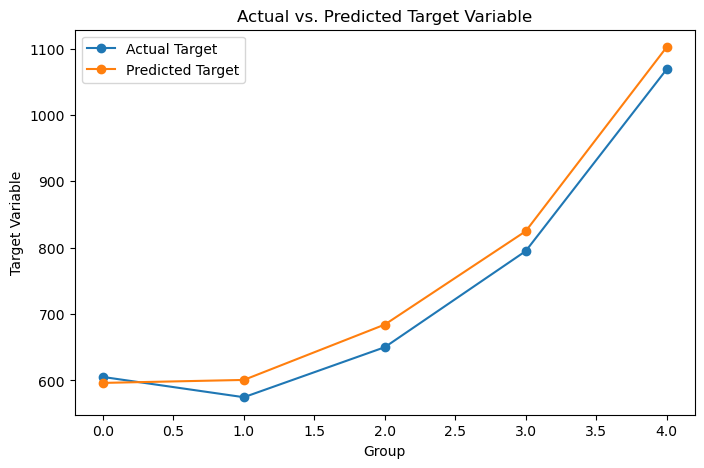

In [9]:
plt.figure(figsize = (8,5))
plt.plot(rslt_tbl['grp'], rslt_tbl['act_target'], marker = 'o', linestyle = '-', label = 'Actual Target')
plt.plot(rslt_tbl['grp'], rslt_tbl['pred_target'], marker = 'o', linestyle = '-', label = 'Predicted Target')

#Adding labels and title
plt.xlabel('Group')
plt.ylabel('Target Variable')
plt.title('Actual vs. Predicted Target Variable')
plt.legend()

#show the plot
plt.show()

### Make predictions on the testing set

In [10]:
test_rslt = pd.DataFrame({'act_target': y_test,
                          'weight': w_test,
                          'pred_target': xgb_reg.predict(X_test),
                         'prior_loss_ind': X_test['loss_free_yrs_total']==5})


# Create a summary decile table
# First, split so that every record with no prior claim is in its own table.
test_rslta = test_rslt.loc[test_rslt['prior_loss_ind']].copy()

# And every record with a prior claim is in a diferent table.
test_rsltb = test_rslt.loc[test_rslt['prior_loss_ind']==False].copy()

# Sort a DataFrame by predicted target variable in ascending order, inplace = true will not return a new dataframe. 
test_rsltb.sort_values(by = 'pred_target', ascending = True, inplace = True) 

# Create deciles
# Scale the cumulative proportion into bins. Each bin representing equal percentage of the cumulative distribution
num_bins = 4
test_rsltb['grp'] = test_rsltb['weight'].cumsum() / sum(test_rsltb['weight']) * num_bins
test_rsltb['grp'] = test_rsltb.apply(lambda x: math.ceil(x['grp']),axis=1)

# Records without a prior claim are assigned bin = 0
test_rslta['grp'] = 0

# Stack the two dataframes. The result has bins from 0 - n
test_rslt = pd.concat([test_rslta, test_rsltb], ignore_index = True)

# The actual and predicted targets are pure premiums. Before summing, we have to multiply by the weighted (earned exposure years) to get losses. 
# Pure premium cannot be summed, but losses can.
test_rslt['act_loss'] = test_rslt['act_target'] * test_rslt['weight']
test_rslt['pred_loss'] = test_rslt['pred_target'] * test_rslt['weight']

# Rebalance so that total predicted loss = total actual loss.
test_rslt['pred_loss'] = test_rslt['pred_loss'] * sum(test_rslt['act_loss']) / sum(test_rslt['pred_loss'])

# Aggregate by decile
test_rslt_tbl = test_rslt.groupby('grp').agg({'weight':'sum',
                                    'act_loss': 'sum',
                                    'pred_loss': 'sum'}).reset_index()

# Now divide the losses by the weight (exposures) to get average pure premium by group.
test_rslt_tbl['act_target'] = test_rslt_tbl['act_loss'] / test_rslt_tbl['weight']
test_rslt_tbl['pred_target'] = test_rslt_tbl['pred_loss'] / test_rslt_tbl['weight']

test_rslt_tbl

,grp,weight,act_loss,pred_loss,act_target,pred_target
0,0,593119.757,3.640849e+08,3.571501e+08,613.847254,602.155040
1,1,43383.595,2.621569e+07,2.631241e+07,604.276568,606.505984
2,2,43384.654,2.677993e+07,2.999023e+07,617.267347,691.263588
3,3,43384.665,3.808301e+07,3.617096e+07,877.798834,833.726736
4,4,43385.241,4.225485e+07,4.779477e+07,973.945285,1101.636522


### Testing Data Plot

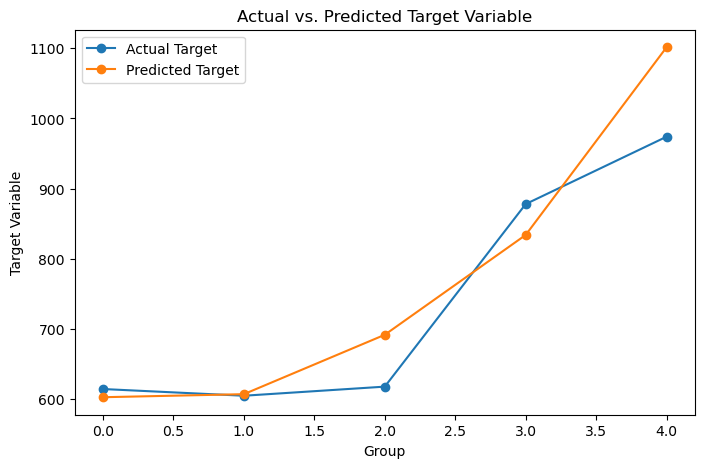

In [11]:
plt.figure(figsize = (8,5))
plt.plot(test_rslt_tbl['grp'], test_rslt_tbl['act_target'], marker = 'o', linestyle = '-', label = 'Actual Target')
plt.plot(test_rslt_tbl['grp'], test_rslt_tbl['pred_target'], marker = 'o', linestyle = '-', label = 'Predicted Target')

#Adding labels and title
plt.xlabel('Group')
plt.ylabel('Target Variable')
plt.title('Actual vs. Predicted Target Variable')
plt.legend()

#show the plot
plt.show()

### Hyper Parameter Tuning

In [12]:
%%time
# Defining each individual hyperparameter
booster=['gbtree']
n_estimators = [40, 100]
learning_rate = [0.10, 0.20]
max_depth = [2, 3, 4]
colsample_bytree = [0.80, 0.85]
subsample = [0.70, 0.80, 0.90]
base_score = [100]
reg_alpha = [17]
gamma = [0]
# Create dictionary of the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'booster':booster,
    'base_score':base_score,
    'colsample_bytree':colsample_bytree,
    'reg_alpha':reg_alpha,
    'gamma':gamma,
    'subsample':subsample,
    'monotone_constraints': [tuple(np.tile([1,1,-1],16))]
    }

# Set up the grid search with 3-fold cross validation
grid_cv1 = GridSearchCV(estimator = xgb_reg, # specify the initial model here.
                        param_grid = hyperparameter_grid,
                        cv=3,
                        #scoring = 'neg_mean_absolute_error',
                        scoring = 'neg_root_mean_squared_error',
                        verbose = 2)

# Perform the grid search
grid_cv1.fit(X=X_train, y=y_train, sample_weight=w_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END base_score=100, booster=gbtree, colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=2, monotone_constraints=(1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1), n_estimators=40, reg_alpha=17, subsample=0.7; total time=   3.7s
[CV] END base_score=100, booster=gbtree, colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=2, monotone_constraints=(1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1), n_estimators=40, reg_alpha=17, subsample=0.7; total time=   3.7s
[CV] END base_score=100, booster=gbtree, colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=2, monotone_constraints=(1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=0.85,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.22, m...
             param_grid={'base_score': [100], 'booster': ['gbtree'],
                         'colsample_bytree': [0.8, 0.85], 'gamma': [0],
                         'learning_rate': [0.1, 0.2], 'max_depth': [2, 3, 4],
                         'monotone_constraints': [(1, 1, -1, 1, 1, -1, 1, 1, -1,
                                                   1, 1, -1, 1, 1, -1, 1, 1, -1,
                                                   1, 1, -1, 1, 1, -1, 1, 1, -1,
                                                   1, 1, -1, ...)],
                         'n_estimators': [40, 100], 'reg_alpha': [17],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='neg_root_mean_squared_error', verbose=2)

[CV] END base_score=100, booster=gbtree, colsample_bytree=0.85, gamma=0, learning_rate=0.2, max_depth=3, monotone_constraints=(1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1), n_estimators=100, reg_alpha=17, subsample=0.8; total time=  11.2s
[CV] END base_score=100, booster=gbtree, colsample_bytree=0.85, gamma=0, learning_rate=0.2, max_depth=3, monotone_constraints=(1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1), n_estimators=100, reg_alpha=17, subsample=0.8; total time=  11.1s
[CV] END base_score=100, booster=gbtree, colsample_bytree=0.85, gamma=0, learning_rate=0.2, max_depth=3, monotone_constraints=(1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1), n_es

CPU times: total: 5h 29min 50s
Wall time: 32min 28s


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=0.85,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.22, m...
             param_grid={'base_score': [100], 'booster': ['gbtree'],
                         'colsample_bytree': [0.8, 0.85], 'gamma': [0],
                         'learning_rate': [0.1, 0.2], 'max_depth': [2, 3, 4],
                         'monotone_constraints': [(1, 1, -1, 1, 1, -1, 1, 1, -1,
                                                   1, 1, -1, 1, 1, -1, 1, 1, -1,
                                                   1, 1, -1, 1, 1, -1, 1, 1, -1,
                                                   1, 1, -1, ...)],
                         'n_estimators': [40, 100], 'reg_alpha': [17],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='neg_root_mean_squared_error', verbose=2)

### Display some of the hyperparameters giving the best fit

In [13]:
print('n_estimators = {}'.format(grid_cv1.best_estimator_.n_estimators))
print('learning_rate = {}'.format(grid_cv1.best_estimator_.learning_rate))
print('max_depth = {}'.format(grid_cv1.best_estimator_.max_depth))
print('colsample_bytree = {}'.format(grid_cv1.best_estimator_.colsample_bytree))
print('subsample = {}'.format(grid_cv1.best_estimator_.subsample))
print('gamma = {}'.format(grid_cv1.best_estimator_.gamma))
print('reg_alpha = {}'.format(grid_cv1.best_estimator_.reg_alpha))
print('base_score = {}'.format(grid_cv1.best_estimator_.base_score))

n_estimators = 40
learning_rate = 0.1
max_depth = 2
colsample_bytree = 0.85
subsample = 0.9
gamma = 0
reg_alpha = 17
base_score = 100


### Evaluate the Best Tuned Model

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score #Imports

# Define a new model using the "best" tuned parameters
xgb_reg1 = grid_cv1.best_estimator_

# Fit the model on the training data
xgb_reg1.fit(X=X_train, y=y_train, sample_weight=w_train)

# View the parameters of the best tuned model
print(xgb_reg1)

# Make predictions on the training data
train_predictions = xgb_reg1.predict(X_train)

# Calculate RMSE for Training Data
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
print(f"Training RMSE: {train_rmse}")

# Make predictions on the testing data
test_predictions = xgb_reg1.predict(X_test)

# Calculate RMSE for Testing Data
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)
print(f"Testing RMSE: {test_rmse}")


XGBRegressor(base_score=100, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.85, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan,
             monotone_constraints=(1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1,
                                   -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1,
                                   1, 1, -1, ...),
             n_estimators=40, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
Training RMSE: 10590.758418766767
Testing RMSE: 10559.669925106991


C:\Users\firas\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\firas\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [16]:
rslt1 = pd.DataFrame({'act_target': y_train, 
                    'weight': w_train,
                    'pred_target': xgb_reg1.predict(X_train),
                    'prior_loss_ind': X_train['loss_free_yrs_total']==5})

# Create a summary decile table
# First, split so that every record with no prior claim is in its own table.
rslt1a = rslt1.loc[rslt1['prior_loss_ind']].copy()

# And every record with a prior claim is in a different table. 
rslt1b = rslt1.loc[rslt1['prior_loss_ind']==False].copy()

# Sort a DataFrame by predicted target variable in ascending order, inplace = true will not return a new dataframe. 
rslt1b.sort_values(by = 'pred_target', ascending = True, inplace = True) 

# Create deciles
# Scale the cumulative proportion into bins. Each bin representing equal percentage of the cumulative distribution
num_bins = 4
rslt1b['grp'] = rslt1b['weight'].cumsum() / sum(rslt1b['weight']) * num_bins
rslt1b['grp'] = rslt1b.apply(lambda x: math.ceil(x['grp']),axis=1)

# Record without a prior claim are assigned bin = 0
rslt1a['grp'] = 0

# Stack the two dataframes. The result has bins from 0 - n
rslt1 = pd.concat([rslt1a,rslt1b], ignore_index = True)

# The actual and predicted targets are pure premiums. Before summing, we have to multiply by the weight (earned exposure years) to get losses. 
# Pure premium cannot be summed, but losess can.
rslt1['act_loss'] = rslt1['act_target'] * rslt1['weight']
rslt1['pred_loss'] = rslt1['pred_target'] * rslt1['weight']

# Rebalance, so that total predicted loss = total actual loss.
rslt1['pred_loss'] = rslt1['pred_loss'] * sum(rslt1['act_loss']) / sum(rslt1['pred_loss'])

# Aggregate by decile
rslt1_tbl = rslt1.groupby('grp').agg({'weight':'sum',
                                    'act_loss': 'sum',
                                    'pred_loss': 'sum'}).reset_index()

# Now divide the losses by the weight (exposures) to get average premium by group
rslt1_tbl['act_target'] = rslt1_tbl['act_loss'] / rslt1_tbl['weight']
rslt1_tbl['pred_target'] = rslt1_tbl['pred_loss'] / rslt1_tbl['weight']

rslt1_tbl

,grp,weight,act_loss,pred_loss,act_target,pred_target
0,0,594189.190,3.596629e+08,3.617532e+08,605.300312,608.818150
1,1,43134.835,2.489977e+07,2.683756e+07,577.254355,622.178403
2,2,43134.532,2.984076e+07,2.866638e+07,691.806670,664.580842
3,3,43134.466,3.455090e+07,3.434241e+07,801.004500,796.171031
4,4,43135.662,4.392953e+07,4.128434e+07,1018.403975,957.081391


### Training Data Plot

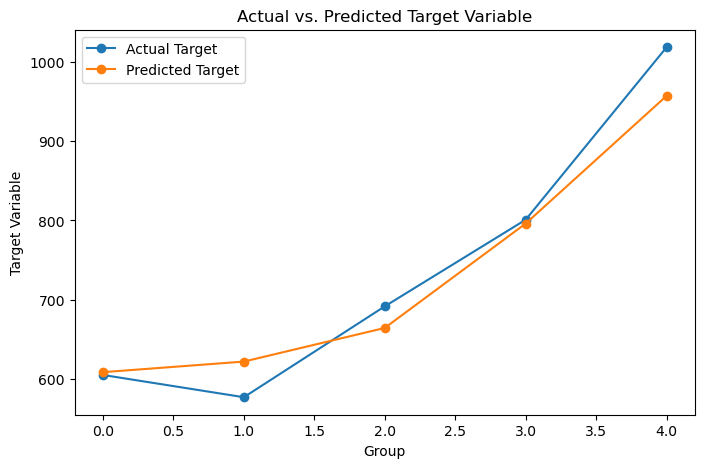

In [17]:
plt.figure(figsize = (8,5))
plt.plot(rslt1_tbl['grp'], rslt1_tbl['act_target'], marker = 'o', linestyle = '-', label = 'Actual Target')
plt.plot(rslt1_tbl['grp'], rslt1_tbl['pred_target'], marker = 'o', linestyle = '-', label = 'Predicted Target')

#Adding labels and title
plt.xlabel('Group')
plt.ylabel('Target Variable')
plt.title('Actual vs. Predicted Target Variable')
plt.legend()

#show the plot
plt.show()

In [18]:
test_rslt1 = pd.DataFrame({'act_target': y_test,
                          'weight': w_test,
                          'pred_target': xgb_reg1.predict(X_test),
                         'prior_loss_ind': X_test['loss_free_yrs_total']==5})


# Create a summary decile table
# First, split so that every record with no prior claim is in its own table.
test_rslt1a = test_rslt1.loc[test_rslt1['prior_loss_ind']].copy()

# And every record with a prior claim is in a diferent table.
test_rslt1b = test_rslt1.loc[test_rslt1['prior_loss_ind']==False].copy()

# Sort a DataFrame by predicted target variable in ascending order, inplace = true will not return a new dataframe. 
test_rslt1b.sort_values(by = 'pred_target', ascending = True, inplace = True) 

# Create deciles
# Scale the cumulative proportion into bins. Each bin representing equal percentage of the cumulative distribution
num_bins = 4
test_rslt1b['grp'] = test_rslt1b['weight'].cumsum() / sum(test_rslt1b['weight']) * num_bins
test_rslt1b['grp'] = test_rslt1b.apply(lambda x: math.ceil(x['grp']),axis=1)

# Records without a prior claim are assigned bin = 0
test_rslt1a['grp'] = 0

# Stack the two dataframes. The result has bins from 0 - n
test_rslt1 = pd.concat([test_rslt1a, test_rslt1b], ignore_index = True)

# The actual and predicted targets are pure premiums. Before summing, we have to multiply by the weighted (earned exposure years) to get losses. 
# Pure premium cannot be summed, but losses can.
test_rslt1['act_loss'] = test_rslt1['act_target'] * test_rslt1['weight']
test_rslt1['pred_loss'] = test_rslt1['pred_target'] * test_rslt1['weight']

# Rebalance so that total predicted loss = total actual loss.
test_rslt1['pred_loss'] = test_rslt1['pred_loss'] * sum(test_rslt1['act_loss']) / sum(test_rslt1['pred_loss'])

# Aggregate by decile
test_rslt1_tbl = test_rslt1.groupby('grp').agg({'weight':'sum',
                                    'act_loss': 'sum',
                                    'pred_loss': 'sum'}).reset_index()

# Now divide the losses by the weight (exposures) to get average pure premium by group.
test_rslt1_tbl['act_target'] = test_rslt1_tbl['act_loss'] / test_rslt1_tbl['weight']
test_rslt1_tbl['pred_target'] = test_rslt1_tbl['pred_loss'] / test_rslt1_tbl['weight']

test_rslt1_tbl

,grp,weight,act_loss,pred_loss,act_target,pred_target
0,0,593119.757,3.640849e+08,3.643830e+08,613.847254,614.349856
1,1,43383.832,2.649977e+07,2.723723e+07,610.821437,627.819876
2,2,43384.764,2.725418e+07,2.910558e+07,628.197094,670.871003
3,3,43383.988,3.722308e+07,3.489415e+07,857.991237,804.309503
4,4,43385.571,4.235644e+07,4.179841e+07,976.279431,963.417315


### Testing data plot

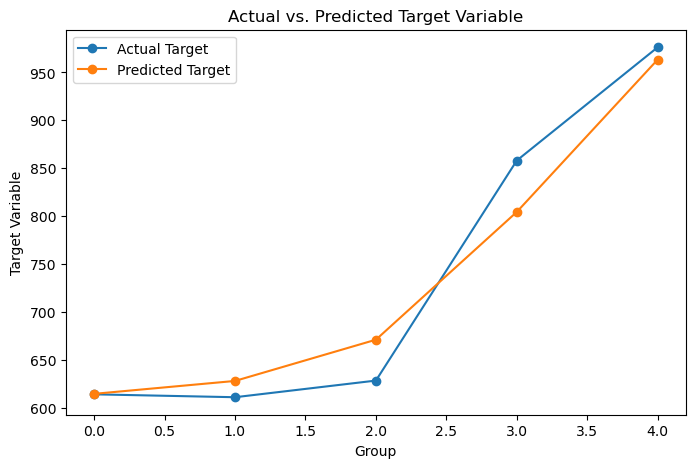

In [19]:
#Test Data Plot

plt.figure(figsize = (8,5))
plt.plot(test_rslt1_tbl['grp'], test_rslt1_tbl['act_target'], marker = 'o', linestyle = '-', label = 'Actual Target')
plt.plot(test_rslt1_tbl['grp'], test_rslt1_tbl['pred_target'], marker = 'o', linestyle = '-', label = 'Predicted Target')

#Adding labels and title
plt.xlabel('Group')
plt.ylabel('Target Variable')
plt.title('Actual vs. Predicted Target Variable')
plt.legend()

#show the plot
plt.show()

## 13. Feature importance 

<Figure size 1200x800 with 0 Axes>

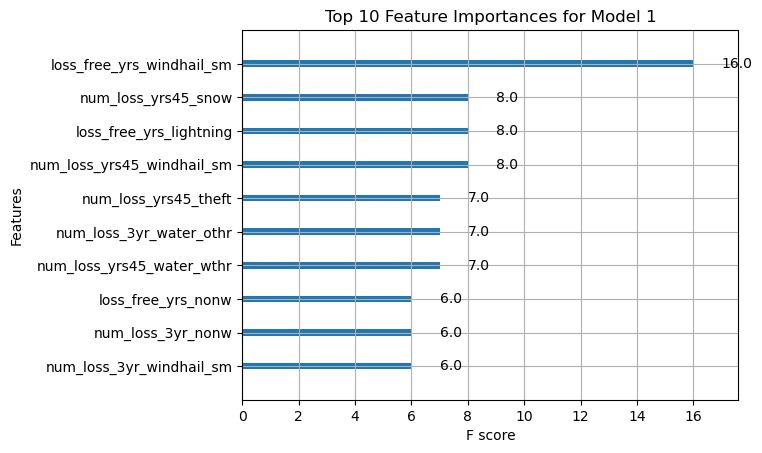


Feature Importances for Model 1:
                         Feature  Importance
36            num_loss_3yr_sewer    0.203159
7     num_loss_yrs45_windhail_sm    0.141932
44            loss_free_yrs_nonw    0.094172
22      num_loss_yrs45_lightning    0.086511
42             num_loss_3yr_nonw    0.047492
37          num_loss_yrs45_sewer    0.047200
17      loss_free_yrs_water_wthr    0.043659
8      loss_free_yrs_windhail_sm    0.041034
16     num_loss_yrs45_water_wthr    0.025151
46          num_loss_yrs45_total    0.024213
38           loss_free_yrs_sewer    0.023691
18       num_loss_3yr_water_othr    0.023164
19     num_loss_yrs45_water_othr    0.021929
23       loss_free_yrs_lightning    0.021207
6       num_loss_3yr_windhail_sm    0.020921
47           loss_free_yrs_total    0.020465
32   loss_free_yrs_other_wo_snow    0.020135
14           loss_free_yrs_water    0.019101
34           num_loss_yrs45_snow    0.018386
25          num_loss_yrs45_theft    0.016163
39        num_loss_3y

In [20]:
from xgboost import plot_importance


# Plot feature importance using XGBoost
plt.figure(figsize=(12, 8))
plot_importance(xgb_reg1, max_num_features=10, importance_type='weight')  # Change max_num_features as needed
plt.title('Top 10 Feature Importances for Model 1')
plt.show()

# Extract feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_reg1.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances for Model 1:")
print(importance_df)

## 14. Generate Decile Charts after feature selection


Decile Chart for Training Data:
   grp      weight      act_loss     pred_loss   act_target  pred_target
0    0  594189.190  3.596629e+08  3.617532e+08   605.300312   608.818150
1    1   43134.835  2.489977e+07  2.683756e+07   577.254355   622.178403
2    2   43134.532  2.984076e+07  2.866638e+07   691.806670   664.580842
3    3   43134.466  3.455090e+07  3.434241e+07   801.004500   796.171031
4    4   43135.662  4.392953e+07  4.128434e+07  1018.403975   957.081391


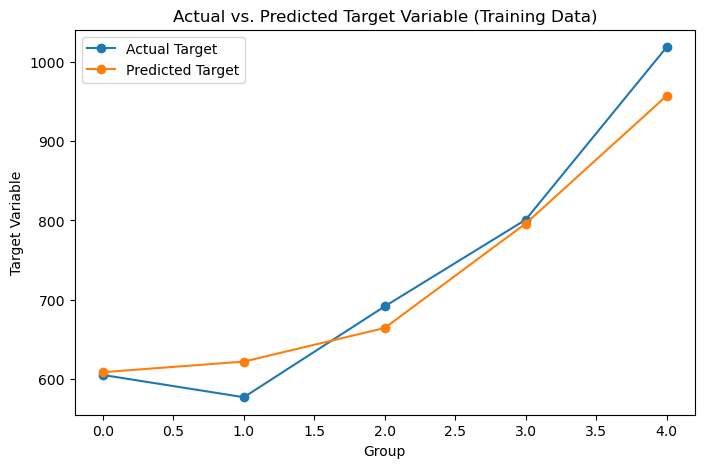


Decile Chart for Testing Data:
   grp      weight      act_loss     pred_loss  act_target  pred_target
0    0  593119.757  3.640849e+08  3.643830e+08  613.847254   614.349856
1    1   43383.832  2.649977e+07  2.723723e+07  610.821437   627.819876
2    2   43384.764  2.725418e+07  2.910558e+07  628.197094   670.871003
3    3   43383.988  3.722308e+07  3.489415e+07  857.991237   804.309503
4    4   43385.571  4.235644e+07  4.179841e+07  976.279431   963.417315


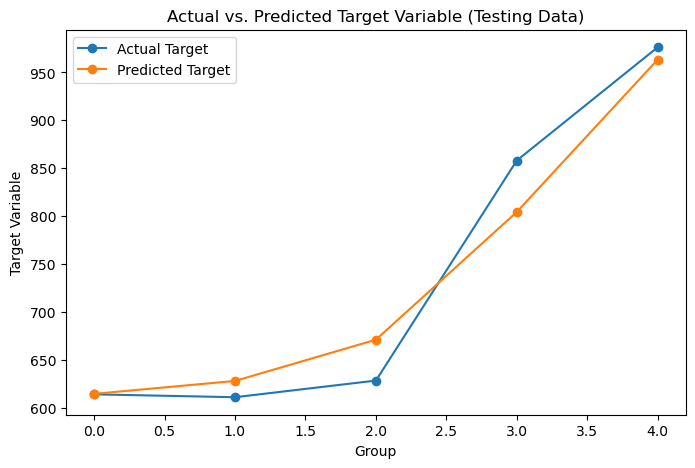

In [21]:



# Define a function to create decile charts
def create_decile_chart(model, X, y, w, dataset_type='Training'):
    """
    Generates and plots a decile chart for the given dataset.

    Parameters:
    - model: Trained regression model.
    - X: Features dataset.
    - y: Actual target values.
    - w: Sample weights.
    - dataset_type: 'Training' or 'Testing' to specify the dataset.
    
    Returns:
    - decile_table: DataFrame containing aggregated decile information.
    """
    # Make predictions
    predictions = model.predict(X)
    
    # Create a DataFrame for the results
    rslt = pd.DataFrame({
        'act_target': y,
        'weight': w,
        'pred_target': predictions,
        'prior_loss_ind': X['loss_free_yrs_total'] == 5  # Adjust the feature name if different
    })
    
    # Split the data based on prior loss indicator
    rslt_no_prior = rslt[rslt['prior_loss_ind']].copy()
    rslt_prior = rslt[~rslt['prior_loss_ind']].copy()
    
    # Assign group 0 to records without prior claims
    rslt_no_prior['grp'] = 0
    
    # Sort the records with prior claims by predicted target
    rslt_prior.sort_values(by='pred_target', ascending=True, inplace=True)
    
    # Create deciles based on cumulative weight
    num_bins = 4  # Number of groups (e.g., quartiles)
    rslt_prior['cum_weight'] = rslt_prior['weight'].cumsum()
    rslt_prior['grp'] = (rslt_prior['cum_weight'] / rslt_prior['weight'].sum() * num_bins).apply(math.ceil)
    
    # Ensure group numbers do not exceed num_bins
    rslt_prior['grp'] = rslt_prior['grp'].clip(upper=num_bins)
    
    # Combine the two DataFrames
    rslt_combined = pd.concat([rslt_no_prior, rslt_prior], ignore_index=True)
    
    # Calculate actual and predicted losses
    rslt_combined['act_loss'] = rslt_combined['act_target'] * rslt_combined['weight']
    rslt_combined['pred_loss'] = rslt_combined['pred_target'] * rslt_combined['weight']
    
    # Rebalance predicted losses to match actual losses
    total_act_loss = rslt_combined['act_loss'].sum()
    total_pred_loss = rslt_combined['pred_loss'].sum()
    rslt_combined['pred_loss'] = rslt_combined['pred_loss'] * (total_act_loss / total_pred_loss)
    
    # Aggregate by group
    decile_table = rslt_combined.groupby('grp').agg({
        'weight': 'sum',
        'act_loss': 'sum',
        'pred_loss': 'sum'
    }).reset_index()
    
    # Calculate average premiums
    decile_table['act_target'] = decile_table['act_loss'] / decile_table['weight']
    decile_table['pred_target'] = decile_table['pred_loss'] / decile_table['weight']
    
    print(f"\nDecile Chart for {dataset_type} Data:")
    print(decile_table)
    
    # Plot the Decile Chart
    plt.figure(figsize=(8,5))
    plt.plot(decile_table['grp'], decile_table['act_target'], marker='o', linestyle='-', label='Actual Target')
    plt.plot(decile_table['grp'], decile_table['pred_target'], marker='o', linestyle='-', label='Predicted Target')
    
    # Adding labels and title
    plt.xlabel('Group')
    plt.ylabel('Target Variable')
    plt.title(f'Actual vs. Predicted Target Variable ({dataset_type} Data)')
    plt.legend()
    
    # Show the plot
    plt.show()
    
    return decile_table

# Generate Decile Chart for Training Data
train_decile_tbl = create_decile_chart(
    model=xgb_reg1, 
    X=X_train, 
    y=y_train, 
    w=w_train, 
    dataset_type='Training'
)

# Generate Decile Chart for Testing Data
test_decile_tbl = create_decile_chart(
    model=xgb_reg1, 
    X=X_test, 
    y=y_test, 
    w=w_test, 
    dataset_type='Testing'
)


### feature importances: 
#### for each individual features, all features grouped by perils and all features grouped by class.


Decile Chart for Training Data:
   grp      weight      act_loss     pred_loss   act_target  pred_target
0    0  594189.190  3.596629e+08  3.617532e+08   605.300312   608.818150
1    1   43134.835  2.489977e+07  2.683756e+07   577.254355   622.178403
2    2   43134.532  2.984076e+07  2.866638e+07   691.806670   664.580842
3    3   43134.466  3.455090e+07  3.434241e+07   801.004500   796.171031
4    4   43135.662  4.392953e+07  4.128434e+07  1018.403975   957.081391


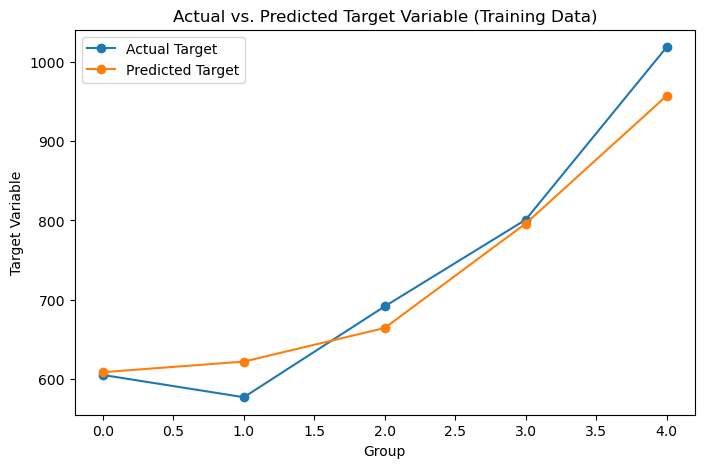


Decile Chart for Testing Data:
   grp      weight      act_loss     pred_loss  act_target  pred_target
0    0  593119.757  3.640849e+08  3.643830e+08  613.847254   614.349856
1    1   43383.832  2.649977e+07  2.723723e+07  610.821437   627.819876
2    2   43384.764  2.725418e+07  2.910558e+07  628.197094   670.871003
3    3   43383.988  3.722308e+07  3.489415e+07  857.991237   804.309503
4    4   43385.571  4.235644e+07  4.179841e+07  976.279431   963.417315


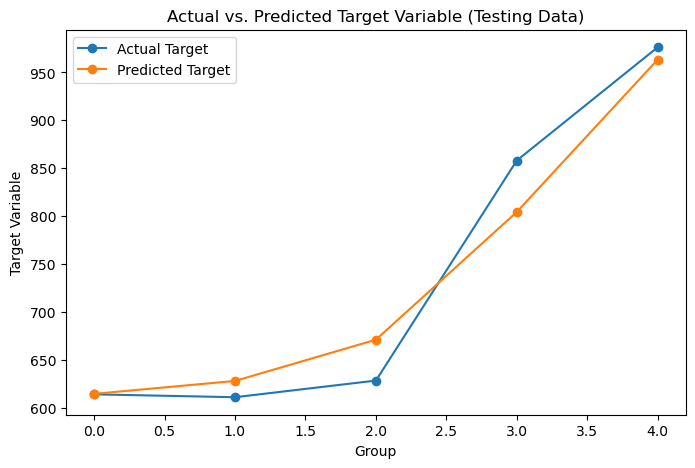


Class-wise Feature Importances (Training):
{'num_loss_3yr':                        Feature  Importance
36          num_loss_3yr_sewer    0.203159
42           num_loss_3yr_nonw    0.047492
18     num_loss_3yr_water_othr    0.023164
6     num_loss_3yr_windhail_sm    0.020921
39      num_loss_3yr_liability    0.013244
30  num_loss_3yr_other_wo_snow    0.000000
45          num_loss_3yr_total    0.000000
33           num_loss_3yr_snow    0.000000
0            num_loss_3yr_fire    0.000000
12          num_loss_3yr_water    0.000000
3        num_loss_3yr_windhail    0.000000
9     num_loss_3yr_windhail_lg    0.000000
15     num_loss_3yr_water_wthr    0.000000
21      num_loss_3yr_lightning    0.000000
27   num_loss_3yr_other_w_snow    0.000000
24          num_loss_3yr_theft    0.000000, 'num_loss_yrs45':                          Feature  Importance
7     num_loss_yrs45_windhail_sm    0.141932
22      num_loss_yrs45_lightning    0.086511
37          num_loss_yrs45_sewer    0.047200
16     nu

In [22]:
# Define the function to create a decile chart, including feature importance by class and peril
def create_decile_chart_with_importance(model, X, y, w, dataset_type='Training'):
    """
    Generates and plots a decile chart for the given dataset, including feature importance by class and peril.
    
    Parameters:
    - model: Trained regression model.
    - X: Features dataset.
    - y: Actual target values.
    - w: Sample weights.
    - dataset_type: 'Training' or 'Testing' to specify the dataset.
    
    Returns:
    - decile_table: DataFrame containing aggregated decile information.
    - feature_importance_by_class: DataFrame with feature importance aggregated by class.
    - feature_importance_by_peril: DataFrame with feature importance aggregated by peril.
    """
    
    # Make predictions
    predictions = model.predict(X)
    
    # Create a DataFrame for the results
    rslt = pd.DataFrame({
        'act_target': y,
        'weight': w,
        'pred_target': predictions,
        'prior_loss_ind': X['loss_free_yrs_total'] == 5  # Adjust the feature name if different
    })
    
    # Split the data based on prior loss indicator
    rslt_no_prior = rslt[rslt['prior_loss_ind']].copy()
    rslt_prior = rslt[~rslt['prior_loss_ind']].copy()
    
    # Assign group 0 to records without prior claims
    rslt_no_prior['grp'] = 0
    
    # Sort the records with prior claims by predicted target
    rslt_prior.sort_values(by='pred_target', ascending=True, inplace=True)
    
    # Create deciles based on cumulative weight
    num_bins = 4  # Number of groups (e.g., quartiles)
    rslt_prior['cum_weight'] = rslt_prior['weight'].cumsum()
    rslt_prior['grp'] = (rslt_prior['cum_weight'] / rslt_prior['weight'].sum() * num_bins).apply(math.ceil)
    
    # Ensure group numbers do not exceed num_bins
    rslt_prior['grp'] = rslt_prior['grp'].clip(upper=num_bins)
    
    # Combine the two DataFrames
    rslt_combined = pd.concat([rslt_no_prior, rslt_prior], ignore_index=True)
    
    # Calculate actual and predicted losses
    rslt_combined['act_loss'] = rslt_combined['act_target'] * rslt_combined['weight']
    rslt_combined['pred_loss'] = rslt_combined['pred_target'] * rslt_combined['weight']
    
    # Rebalance predicted losses to match actual losses
    total_act_loss = rslt_combined['act_loss'].sum()
    total_pred_loss = rslt_combined['pred_loss'].sum()
    rslt_combined['pred_loss'] = rslt_combined['pred_loss'] * (total_act_loss / total_pred_loss)
    
    # Aggregate by group
    decile_table = rslt_combined.groupby('grp').agg({
        'weight': 'sum',
        'act_loss': 'sum',
        'pred_loss': 'sum'
    }).reset_index()
    
    # Calculate average premiums
    decile_table['act_target'] = decile_table['act_loss'] / decile_table['weight']
    decile_table['pred_target'] = decile_table['pred_loss'] / decile_table['weight']
    
    print(f"\nDecile Chart for {dataset_type} Data:")
    print(decile_table)
    
    # Plot the Decile Chart
    plt.figure(figsize=(8,5))
    plt.plot(decile_table['grp'], decile_table['act_target'], marker='o', linestyle='-', label='Actual Target')
    plt.plot(decile_table['grp'], decile_table['pred_target'], marker='o', linestyle='-', label='Predicted Target')
    
    # Adding labels and title
    plt.xlabel('Group')
    plt.ylabel('Target Variable')
    plt.title(f'Actual vs. Predicted Target Variable ({dataset_type} Data)')
    plt.legend()
    
    # Show the plot
    plt.show()
    
    # Calculate feature importance by class and peril
    # Define the column names for each class and peril (you need to adjust these lists based on your data)
    class_columns = {
        'num_loss_3yr': [col for col in X.columns if col.startswith('num_loss_3yr')],
        'num_loss_yrs45': [col for col in X.columns if col.startswith('num_loss_yrs45')],
        'loss_free_yrs': [col for col in X.columns if col.startswith('loss_free_yrs')]
    }

    peril_columns = {
        'fire': [col for col in X.columns if 'fire' in col],
        'windhail': [col for col in X.columns if 'windhail' in col],
        'water': [col for col in X.columns if 'water' in col],
        'windhail_sm': [col for col in X.columns if 'windhail_sm' in col],
        'windhail_lg': [col for col in X.columns if 'windhail_lg' in col],
        'lightning': [col for col in X.columns if 'lightning' in col],
        'water_wthr': [col for col in X.columns if 'water_wthr' in col],
        'theft': [col for col in X.columns if 'theft' in col],
        'water_othr': [col for col in X.columns if 'water_othr' in col],
        'other_w_snow': [col for col in X.columns if 'other_w_snow' in col],
        'other_wo_snow': [col for col in X.columns if 'other_wo_snow' in col],
        'snow': [col for col in X.columns if 'snow' in col],
        'sewer': [col for col in X.columns if 'sewer' in col],
        'liability': [col for col in X.columns if 'liability' in col],
        'nonw': [col for col in X.columns if 'nonw' in col],
        'total': [col for col in X.columns if 'total' in col],
    }

    # Extract feature importances from the model
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    # Group by class
    feature_importance_by_class = {class_name: feature_importances[feature_importances['Feature'].isin(cols)] 
                                  for class_name, cols in class_columns.items()}
    
    # Group by peril
    feature_importance_by_peril = {peril_name: feature_importances[feature_importances['Feature'].isin(cols)] 
                                   for peril_name, cols in peril_columns.items()}
    
    # Return decile table and feature importance results
    return decile_table, feature_importance_by_class, feature_importance_by_peril

# Generate Decile Chart for Training Data
train_decile_tbl, train_class_importance, train_peril_importance = create_decile_chart_with_importance(
    model=xgb_reg1, 
    X=X_train, 
    y=y_train, 
    w=w_train, 
    dataset_type='Training'
)

# Generate Decile Chart for Testing Data
test_decile_tbl, test_class_importance, test_peril_importance = create_decile_chart_with_importance(
    model=xgb_reg1, 
    X=X_test, 
    y=y_test, 
    w=w_test, 
    dataset_type='Testing'
)

# Print the class-wise and peril-wise feature importance for both training and testing datasets
print("\nClass-wise Feature Importances (Training):")
print(train_class_importance)

print("\nPeril-wise Feature Importances (Training):")
print(train_peril_importance)

print("\nClass-wise Feature Importances (Testing):")
print(test_class_importance)

print("\nPeril-wise Feature Importances (Testing):")
print(test_peril_importance)


### rmse formula 

In [24]:
# Ensure predictions and actual values are properly prepared (e.g., inverse transformed if necessary)
y_test_exp = np.array(y_test)  # Replace with the appropriate inverse transform if values are scaled
y_pred_exp = np.array(xgb_reg1.predict(X_test))  # Replace with inverse transform if applicable

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_exp, y_pred_exp, sample_weight=w_test)
rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp, sample_weight=w_test))
r2 = r2_score(y_test_exp, y_pred_exp, sample_weight=w_test)
#mape = mean_absolute_percentage_error(y_test_exp, y_pred_exp, sample_weight=w_test) * 100  # Multiply by 100 to get percentage

# Print the evaluation metrics
print("\nModel Evaluation Metrics on Test Set:")
#print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
#print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R^2 Score: {r2:.4f}")


Model Evaluation Metrics on Test Set:
Root Mean Squared Error (RMSE): 7523.8624
R^2 Score: 0.0001


In [26]:

# 1. Configure MLflow to talk to your EC2 server
mlflow.set_tracking_uri("http://3.146.46.179:5000")

# Optional: Set an experiment name so runs go there (or use default experiment)
mlflow.set_experiment("MyXGBoostExperiment")

# Suppose you have a trained XGBoost model called 'new_model'
# new_model = ...

# 2. Save model locally as 'model.joblib'
joblib.dump(xgb_reg1, "Model1.joblib")

# 3. Upload 'model.joblib' to your S3 bucket, e.g. "grange-seniordesign-bucket/models/model.joblib"
s3 = boto3.client("s3")
bucket_name = "grange-seniordesign-bucket"
s3_key = "models/Model1.joblib"  # place it under 'models/' folder
s3.upload_file("Model1.joblib", bucket_name, s3_key)
print(f"Uploaded Model1.joblib to s3://{bucket_name}/{s3_key}")

# 4. Start an MLflow run, log the XGBoost model to your EC2-based MLflow
with mlflow.start_run():
    # Register (or just log) the model in MLflow
    mlflow.xgboost.log_model(
        xgb_model=xgb_reg1,
        artifact_path="mlflow-artifacts",
        registered_model_name="HomeownerLossModel_Model_1"  # e.g., add your model number here
    )

    # Optionally log the local .joblib file as an MLflow artifact too (not required, but if you want it in the run artifacts):
    mlflow.log_artifact("Model1.joblib", artifact_path="joblib_files")

print("Successfully logged model to MLflow at http://3.146.46.179:5000")


Uploaded Model1.joblib to s3://grange-seniordesign-bucket/models/Model1.joblib


C:\Users\firas\anaconda3\Lib\site-packages\xgboost\sklearn.py:761: UserWarning: monotone_constraints is not saved in Scikit-Learn meta.
  self.subsample = subsample
2025/03/11 16:51:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'HomeownerLossModel_Model_1'.
2025/03/11 16:51:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: HomeownerLossModel_Model_1, version 1
Created version '1' of model 'HomeownerLossModel_Model_1'.


🏃 View run adorable-rat-760 at: http://3.146.46.179:5000/#/experiments/10/runs/a8aa3b4dedea43babee9a5e469360055
🧪 View experiment at: http://3.146.46.179:5000/#/experiments/10
Successfully logged model to MLflow at http://3.146.46.179:5000
